In [30]:
import pandas as pd
import numpy as np

# Load data
data = np.fromfile('./servinsp1.dat', dtype=np.float64, sep="\n")

# Sort data
ordered_data = np.sort(data)


In [31]:
import matplotlib.pyplot as plt
import scipy.stats as stats


# Create bins for histogram using class intervals defined by equal probability
mean = np.mean(data)
variance = np.var(data)

num_bins = 20

class_intervals = np.fromfunction(lambda i: (-1/(1/mean))*np.log(1-(i/num_bins)), shape=(num_bins,), dtype=np.float64)

new_class_intervals = np.fromfunction(lambda i: stats.expon.ppf(i/num_bins, scale=mean), shape=(num_bins,))

# class_intervals = np.fromfunction(lambda i: (-1/(1/mean))*np.log(1-(i/num_bins)), shape=(num_bins,), dtype=np.float64)

# Add max value to class intervals to ensure that last bin is shown on chart
class_intervals = np.append(class_intervals, np.ceil(np.max(data)))
# print(class_intervals)

# Create table for data
bar_data = pd.DataFrame({
    'interval_start': class_intervals[:-1],
    'interval_end': class_intervals[1:]
})

In [32]:
# Add actual frequency count to the data table
bar_data['actual_freq'] = [(lambda n: np.count_nonzero((data >= bar_data['interval_start'][n]) & (data < bar_data['interval_end'][n])))(n) for n in range(20)]

In [33]:
# Add expected frequency to the data table
bar_data['expected_freq'] = [(lambda x: len(data) * (stats.expon.cdf(x=bar_data['interval_end'][x], scale=mean) - stats.expon.cdf(x=bar_data['interval_start'][x], scale=mean)))(x) for x in range(len(bar_data))]

In [34]:
# Add chi square test to the table
bar_data['chi_square'] = [(lambda x: ((bar_data['actual_freq'][x] - bar_data['expected_freq'][x]) ** 2) / bar_data['expected_freq'][x])(x) for x in range(len(bar_data))]

chisquared = Power_divergenceResult(statistic=16.60421046348803, pvalue=0.6166620817945669)


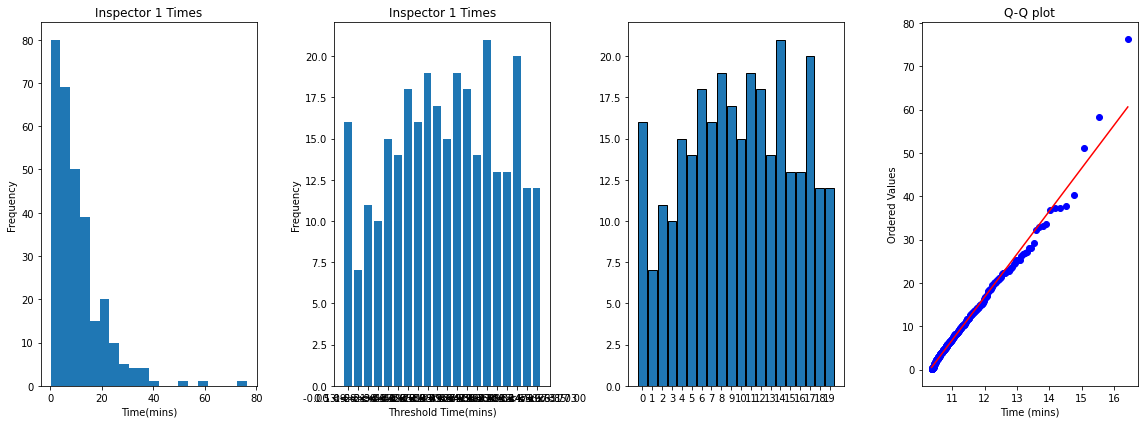

In [35]:

# Create bar chart from data
fig, ax = plt.subplots(nrows=1, ncols=4)


# Histogram with bins of equal width
n, bins, patches = ax[0].hist(data, bins=num_bins)
ax[0].set_title('Inspector 1 Times')
ax[0].set_xlabel('Time(mins)')
ax[0].set_ylabel('Frequency')


threshold = ['{:.2f} <= x < {:.2f}'.format(start, end) for start, end in zip(bar_data['interval_start'], bar_data['interval_end'])]
ax[1].bar(threshold, bar_data['actual_freq'])

ax[1].set_title('Inspector 1 Times')
ax[1].set_xlabel('Threshold Time(mins)')
ax[1].set_ylabel('Frequency')
# plt.xticks(rotation=90)

# Create histogram
n, bins = np.histogram(data, bins=class_intervals)
ax[2].bar(range(len(bar_data)), n, width=0.9, edgecolor='black')
ax[2].set_xticks(range(len(bar_data)))

cs = stats.chisquare(f_obs=bar_data['actual_freq'], f_exp=bar_data['expected_freq'])

print('chisquared = {}'.format(cs))

# Create Q-Q plot for data
# data_df = pd.DataFrame({'data': data})
# data_df['yj'] = data_df.index
# data_df['yj'] = data_df.apply(lambda row: (row['yj'] - 0.5)/len(data_df), axis=1)
# data_df['f_inv'] = data_df.apply(lambda row: stats.expon.ppf(row['yj']), axis=1)

# ax[2].plot(data_df['yj'], data_df['f_inv'], 'o', color='black')

stats.probplot(x=data, dist='expon', plot=ax[3], sparams=(mean))
ax[3].set_title('Q-Q plot')
ax[3].set_xlabel('Time (mins)')


fig.set_size_inches(16, 6, forward=True)
fig.tight_layout()


# plt.xticks(rotation=90)

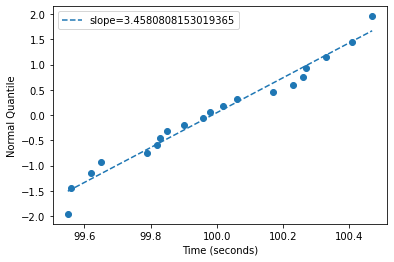

In [6]:

# Plot ordered data on graph

fig, ax = plt.subplots(nrows=1, ncols=1)

robot_df = pd.DataFrame(data={'robotData': [99.55, 99.82, 99.98, 100.26, 99.56, 99.83, 100.02, 100.27, 99.62, 99.85, 100.06, 100.33, 99.65, 99.90, 100.17, 100.41, 99.79, 99.96, 100.23, 100.47]})

# Sort and fix index
robot_df = robot_df.sort_values(by='robotData', ignore_index=True)
robot_df.index += 1 # Shift index

# Add yj and ppf
robot_df['yj'] = robot_df.index
robot_df['yj'] = robot_df.apply(lambda row: (row['yj'] - 0.5)/len(robot_df), axis=1)
robot_df['f_inv'] = robot_df.apply(lambda row: stats.norm.ppf(row['yj']), axis=1)


# Make plot
ax.scatter(robot_df['robotData'], robot_df['f_inv'])
ax.set_ylabel('Normal Quantile')
ax.set_xlabel('Time (seconds)')

# Add line of best fit
m, b = np.polyfit(robot_df['robotData'], robot_df['f_inv'], 1)
ax.plot(robot_df['robotData'], m*robot_df['robotData'] + b, label='slope={}'.format(m), linestyle='dashed')
ax.legend(loc='upper left')


plt.show()


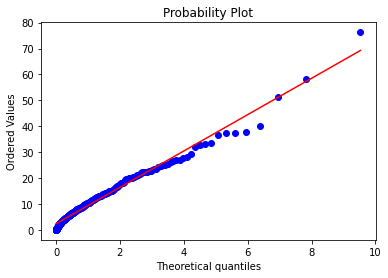

In [31]:
import scipy.stats as stats

stats.probplot(data, dist='exponweib', plot=plt, sparams=(1, 0.8))
plt.show()

cs = None



In [ ]:
# Calculate sample mean

def get_sample_mean(bin_count, bin_edges, num_points):
    '''Get the sample mean for data grouped into class intervals. Works best with numpy arrays from the creation of a histogram i.e. bin_count, bin_edges = plt.hist()'''
    curr_sum = 0
    for index, (edge, freq) in enumerate(zip(bin_edges[1:], bin_count)):
        curr_sum += (freq * (edge - bin_edges[index]))
    
    return curr_sum / num_points


def get_sample_variance(bin_count, bin_edges, num_points, sample_mean):
    '''Get the sample mean for data grouped into class intervals. Works best with numpy arrays from the creation of a histogram i.e. bin_count, bin_edges = plt.hist()'''
    curr_sum = 0
    for index, (edge, freq) in enumerate(zip(bin_edges[1:], bin_count)):
        curr_sum += (freq * ((edge - bin_edges[index])**2))
    
    return (curr_sum - (len(bin_count) * sample_mean**2)) / (num_points - 1)


sample_mean = get_sample_mean(n, bins, len(data))
sample_variance = get_sample_variance(n, bins, len(data), sample_mean)